**Snapshots**: https://www.tng-project.org/data/downloads/TNG300-1/

In [84]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam


In [85]:
import matplotlib.pyplot as plt


In [86]:
metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


In [87]:
SNAPS = np.arange(0, 100, 1)
TNG_H = 0.6774 # from website


In [88]:
def _convert_tng_mass(gmass):
    # TNG units are 1e10 Msun / h; https://www.tng-project.org/data/docs/specifications
    # robust to 0 mass
    return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


def _get_vmax_over_vvir(cat: pd.DataFrame):
    # compute vvir and create new column
    from multicam.parameters import get_vvir
    # ensure units of mvir is in units of Msun / h
    mvir = 10**cat['Mvir'].values / TNG_H # og units: log10(msun)
    rvir = cat['Rvir'].values / TNG_H # og units: kpc
    vvir = get_vvir(rvir, mvir)

    return cat['Vmax_DM'] / vvir


In [89]:
def _reverse_trees(trees):
    """Reverse each entry in trees so that order is from early to late times."""
    for tree in trees:
        for key in tree.keys():
            if key not in ["Number", "ChunkNumber", "TreeID"]:
                tree[key] = tree[key][::-1]
    return trees

def _read_trees(trees_file:str):
    """Read in the trees file and convert masses to log10(M/Msun)."""
    with open(trees_file, 'rb') as pickle_file:
        _trees = pickle.load(pickle_file)
        trees = _reverse_trees(_trees)
        for tree in trees:
            for k in tree.keys():
                if "Mass" in k or "_M_" in k: 
                    tree[k] = _convert_tng_mass(tree[k])
    return trees


In [90]:
def _setup_mah_and_cat(trees_file: str, present_snapfile:str, metadata_file:str, 
                       snaps:np.array, 
                       mass_bin=(12.8, 13.1), 
                       scale_cut=0.185, # corresponds to original paper
                    ):

    # get scales and redshifts
    metadata = pd.read_csv(metadata_file)
    zs = metadata['Redshift'].values
    scales = 1 / (1 + zs)
    assert len(snaps) == len(scales)
    n_snaps = len(snaps)


    # read trees and present-day catalog
    trees = _read_trees(trees_file)
    cat = pd.read_hdf(present_snapfile)

    # select trees in mass bin that have a snapshot at z=0
    trees = [t for t in trees if 99 in t['SnapNum'] 
                and t['Group_M_TopHat200'][-1] > mass_bin[0] 
                and t['Group_M_TopHat200'][-1] < mass_bin[1]]
    
    # get mah from trees, and convert to correct units
    mah = np.zeros((len(trees), n_snaps))
    for ii, t in enumerate(trees):
        mah_t = np.zeros(n_snaps) * np.nan
        t_snaps = t['SnapNum']
        gmass = t['Group_M_TopHat200']
        mah_t[t_snaps] = gmass

        # linearly interpolate nan values 
        mah_t = pd.Series(mah_t)
        mah_t = mah_t.interpolate(method='linear', limit_direction='forward', axis=0)
        mah[ii] = mah_t.values


    idx = np.where(scales > scale_cut)[0][0]
    snaps = snaps[idx:]
    scales = scales[idx:]
    mah = mah[:, idx:]

    # remove haloes with nans and hope not too many
    kp_idx = np.where(np.isnan(mah).sum(axis=1) == 0)[0]
    mah = mah[kp_idx]
    assert np.isnan(mah).sum() < 5

    # turn mah in m_peak 
    # which is the normalized cumulative maximum
    Mpeak = np.fmax.accumulate(mah, axis=1)
    m_peak = Mpeak / Mpeak[:, -1][:, None]

    halo_ids = np.array([t['IndexInHaloTable'][-1] for t in trees])[kp_idx]
    cat = cat.iloc[halo_ids]

    return {'mah': mah, 'present_cat': cat, 'scales': scales, 
            'm_peak': m_peak, 'gmass': mah[:, -1],
            'trees': trees, 'halo_ids': halo_ids, 
            'z': zs, 'snaps': snaps, 
            }



# TNG300-1 

## Setup data

In [20]:
info = _setup_mah_and_cat(trees_file, present_snapfile, metadata_file, SNAPS)


/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_86628/4270742319.py:3: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [21]:
mah, cat, scales, snaps = info['mah'], info['present_cat'], info['scales'], info['snaps']
m_peak = info['m_peak']
trees = info['trees']
gmass = info['gmass']


In [22]:
cat['Vmax_DM/V_vir_DM'] = _get_vmax_over_vvir(cat)


In [23]:
assert len(cat) == len(mah) == len(trees) == len(m_peak)


## Example MAHs

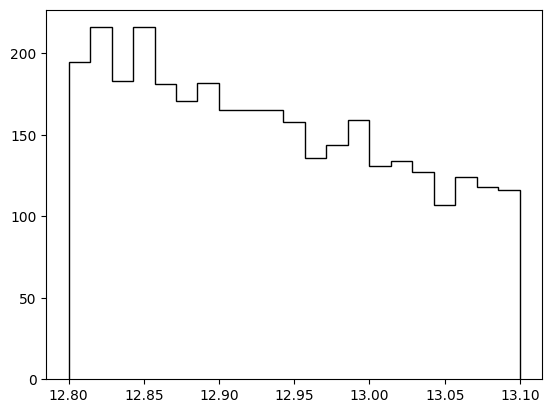

In [24]:
# double check
plt.hist(gmass, bins=21, histtype='step', color='k', label='gmass');


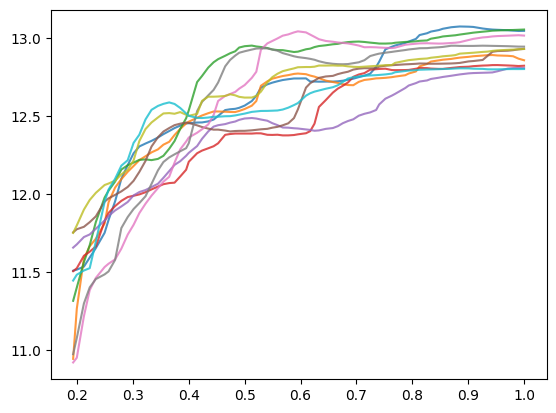

In [26]:
# plot 10 random mah as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(mah))
    plt.plot(scales, mah[idx], '-', alpha=0.8
    );
# plt.plot(scales, mah.T, '-', alpha=0.1, c='k');


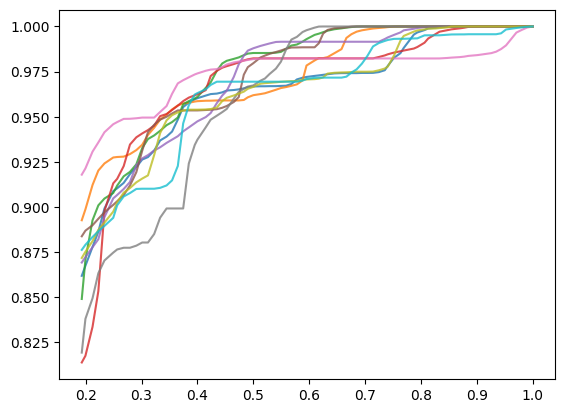

In [27]:
# plot 10 random m_peaks as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(mah))
    plt.plot(scales, m_peak[idx], '-', alpha=0.8
    );


## Create spearman correlation plots

In [28]:
exclude = ["HaloID", "SubhaloID", "SubhaloID_DMO", 'SubhaloID_LastDesc', 'Central', 'Main', 'EndState']


In [29]:
# compute all spearman correlations for every quantity not in exclude
from multicam.correlations import spearmanr
corrs = {} 
for col in cat.columns:
    if col not in exclude:
        corrs[col] = np.zeros(m_peak.shape[1]) * np.nan
        for jj in range(m_peak.shape[1]):
            corrs[col][jj] = spearmanr(cat[col].values, m_peak[:, jj])


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [35]:
# # now plot all correlations (each separately), save to png
# for col in cat.columns:
#     if col not in exclude:
#         plt.figure(figsize=(5, 5))
#         plt.plot(scales, corrs[col], '-', c='k')
#         plt.xlabel("a")
#         plt.ylabel("Spearman r")
#         plt.title(col)
#         plt.savefig(f"../../results/tng/figs/{col}.png", bbox_inches='tight')
#         plt.close()


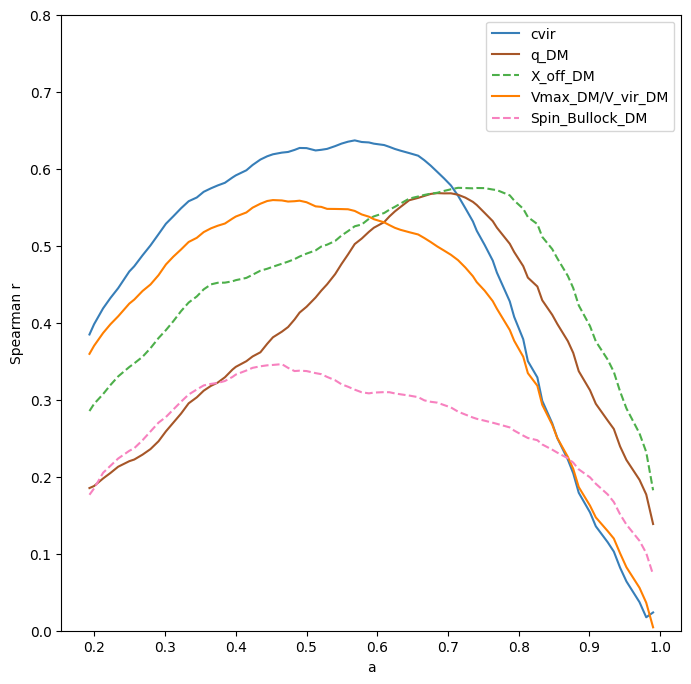

In [30]:
# now plot all correlations (separately), save to png
from multicam.plotting import CB_COLORS
colors_dict = {'cvir': CB_COLORS[0], 
               'Vmax_DM/V_vir_DM': CB_COLORS[1], 
               'X_off_DM': CB_COLORS[2], 
               'Spin_Bullock_DM': CB_COLORS[4],  
               'q_DM': CB_COLORS[5], }
params = {'cvir','Vmax_DM/V_vir_DM', 'X_off_DM', 'Spin_Bullock_DM',  'q_DM', }
assert params.issubset(set(cat.columns))
assert params.issubset(set(corrs.keys()))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for param in params:
        sgn = (sum(corrs[param] > 0) - sum(corrs[param] < 0)) > 0
        style = '-' if sgn else '--'
        
        corr = np.abs(corrs[param])
        ax.plot(scales, corr, style, label=param, color=colors_dict[param])
        ax.set_xlabel("a")
        ax.set_ylabel("Spearman r")
ax.set_ylim(0, 0.8)
ax.legend(loc='best')


## Mean stellar mass - halo mass relation

In [25]:
ratio = np.log10(10**cat['Mstar_30pkpc'] / 10**gmass)
ratio = ratio.values


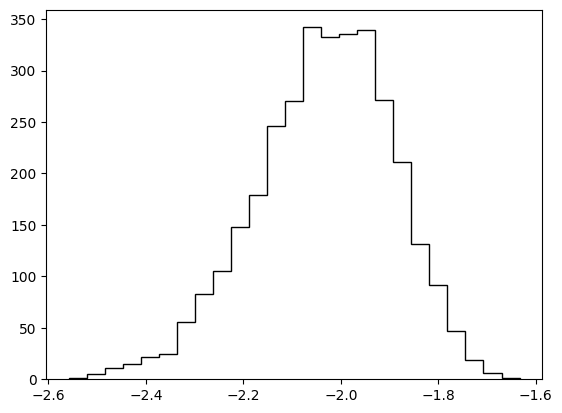

In [26]:
plt.hist(ratio, bins=25, histtype='step', color='k', label='M_{\star} / M_{vir}');


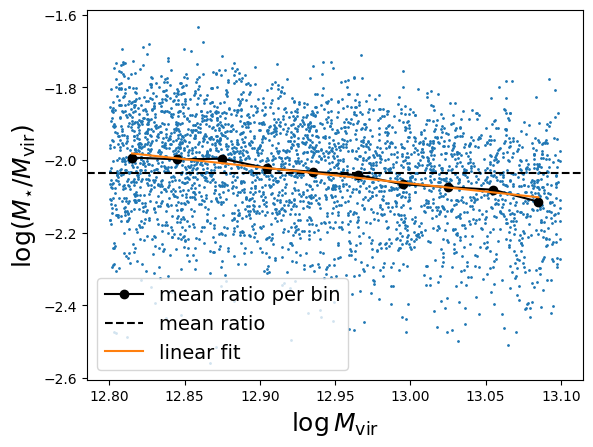

In [27]:
mvir = gmass

plt.scatter(mvir, ratio, s=1, alpha=1)

# compute mean ratio in bins of mvir
bins = np.linspace(12.8, 13.1, 11)
mean_ratio_per_bin = np.zeros(len(bins) - 1)
for ii in range(len(bins) - 1):
    idx = np.where((mvir > bins[ii]) & (mvir < bins[ii+1]))[0]
    mean_ratio_per_bin[ii] = np.mean(ratio[idx])

middle_point_of_bins = (bins[1:] + bins[:-1]) / 2
plt.plot(middle_point_of_bins, mean_ratio_per_bin, 'o-', c='k', label='mean ratio per bin')

plt.axhline(np.mean(ratio), c='k', ls='--', label='mean ratio')

# linear fit 
m, b = np.polyfit(middle_point_of_bins, mean_ratio_per_bin, 1)
plt.plot(middle_point_of_bins, m * middle_point_of_bins + b, '-', c="C1", label='linear fit')

plt.xlabel(r"$\log M_{\rm vir}$", fontsize=18)
plt.ylabel(r"$\log (M_{\star} / M_{\rm vir})$", fontsize=18)

plt.legend(loc='best', fontsize=14)


In [28]:
# finally, calculate deviation from mean log ratio
deviation = ratio - (m * mvir + b)


## Colors

In [56]:
import h5py
f = h5py.File(color_file, 'r')


In [57]:
colnames = 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z', 'wfc_acs_f606w', 'des_y', 'jwst_f150w'
arr = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:]

# average over projections 
arr = np.mean(arr, axis=-1) 
df_color = pd.DataFrame(arr, columns=colnames)

f.close()


In [54]:
df_color


,sdss_u,sdss_g,sdss_r,sdss_i,sdss_z,wfc_acs_f606w,des_y,jwst_f150w
0,-21.223055,-23.152872,-24.002289,-24.423220,-24.798796,-23.874680,-24.980883,-25.278311
1,-20.830639,-22.696707,-23.522802,-23.934675,-24.299194,-23.398367,-24.472525,-24.762300
2,-20.300049,-22.166952,-22.994482,-23.407675,-23.770758,-22.869898,-23.941442,-24.230139
3,-19.530867,-21.333979,-22.139311,-22.542494,-22.890219,-22.017715,-23.050097,-23.330145
4,-19.527555,-21.335581,-22.142946,-22.547743,-22.897932,-22.021103,-23.057770,-23.337908
...,...,...,...,...,...,...,...,...
14485704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14485705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14485706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14485707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#  now to match with haloes from present-day catalog


In [58]:
cat


,HaloID,SubhaloID,SubhaloID_DMO,SubhaloID_LastDesc,Central,Main,Mvir_TNG,Rvir_TNG,pos_x,pos_y,...,J_gas_x,J_gas_y,J_gas_z,Spin_Bullock_star,J_star_x,J_star_y,J_star_z,Mstar_bulge,EndState,Vmax_DM/V_vir_DM
5650,5660,1236405,1540931,1236405,1.0,1.0,12.943673,543.892125,70389.578125,81786.484375,...,0.003448,-0.003777,0.002056,0.000380,0.000152,-0.000335,0.000096,10.972759,Success,1.171313
2477,2477,969605,1214885,969605,1.0,1.0,12.904984,527.993927,78232.476562,58293.589844,...,0.003183,-0.001436,-0.005792,0.000247,0.000171,0.000033,-0.000175,10.676275,Success,1.061623
4527,4527,1163901,1470878,1163901,1.0,1.0,13.040275,585.743240,72759.820312,60659.875000,...,-0.002240,-0.001770,0.000391,0.000265,-0.000263,-0.000025,0.000017,10.992947,Success,1.039059
4470,4470,1159790,1460833,1159790,1.0,1.0,13.065676,597.302752,77812.000000,64696.261719,...,0.004610,0.005898,-0.000660,0.000783,0.000512,0.000569,-0.000165,10.998250,Success,1.211587
7570,7667,1335371,1643185,1335371,1.0,1.0,12.807535,489.933002,75215.437500,55898.472656,...,-0.000376,0.000507,0.000528,0.000173,0.000069,-0.000106,-0.000118,10.972509,Success,1.303791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,7285,1318511,1622531,1318511,1.0,1.0,12.885912,520.324662,161693.093750,33451.621094,...,-0.000450,0.002085,-0.001550,0.000116,0.000007,0.000110,-0.000038,11.075125,Success,1.525042
7891,8025,1349973,1637201,1349973,1.0,1.0,12.851156,506.617836,56911.859375,284728.281250,...,-0.000093,0.001449,-0.000626,0.000058,-0.000044,0.000029,-0.000024,11.066306,Success,1.314956
8694,8950,1385476,1705484,1385476,1.0,1.0,12.810531,491.066351,214165.562500,38708.214844,...,-0.000934,-0.000873,-0.000628,0.000549,-0.000126,-0.000294,-0.000445,10.897066,Success,1.453646
8641,8887,1383133,1689704,1383133,1.0,1.0,12.820341,494.771934,89602.125000,34913.089844,...,0.001158,-0.000690,-0.001997,0.000108,0.000101,-0.000036,-0.000010,10.651169,Success,1.355021


# TNG300-1 Dark 

In [91]:
info_dark = _setup_mah_and_cat(dark_trees_file, present_dark_snapfile, metadata_file, SNAPS)


/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_86628/3987759832.py:4: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [92]:
dm_peak = info_dark['m_peak']
dcat = info_dark['present_cat']
scales = info_dark['scales']
len(dm_peak), len(dcat)


(3854, 3854)

In [93]:
dcat['Vmax_DM/V_vir_DM'] = _get_vmax_over_vvir(dcat)


In [94]:
# check ordering
[t['SubhaloGrNr'][-1] for t in info_dark['trees']][:10], info_dark['present_cat']['HaloID'].values[:10]


([8522, 5516, 9257, 4639, 2437, 7358, 4056, 7073, 3699, 4781],
 array([8522, 5516, 9257, 4639, 2437, 7358, 4056, 7073, 3699, 4781],
       dtype=int32))

(array([521., 501., 428., 391., 403., 388., 323., 320., 300., 279.]),
 array([12.80012512, 12.83010054, 12.86007595, 12.89005136, 12.92002678,
        12.95000219, 12.97997761, 13.00995302, 13.03992844, 13.06990385,
        13.09987926]),
 <BarContainer object of 10 artists>)

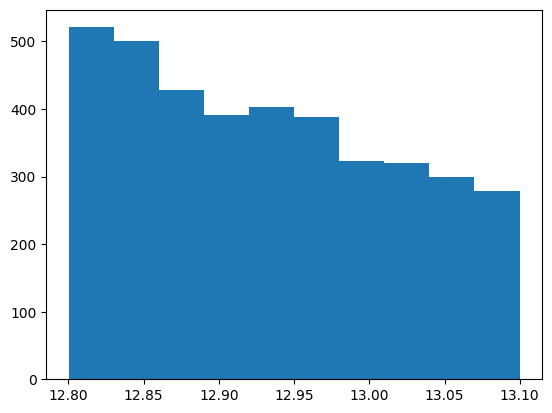

In [95]:
plt.hist(info_dark['gmass'])


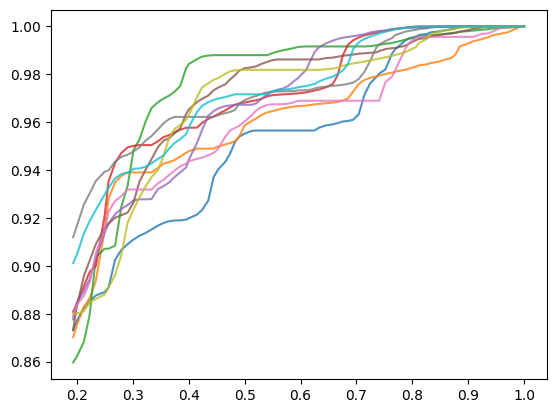

In [96]:
# plot some MAHs 
# plot 10 random m_peaks as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(dm_peak))
    plt.plot(scales, dm_peak[idx], '-', alpha=0.8
    );


In [97]:
exclude = ["HaloID", "SubhaloID", "SubhaloID_LastDesc", 'Central', 'Main', 'EndState']
info_dark['present_cat'].columns


Index(['HaloID', 'SubhaloID', 'SubhaloID_LastDesc', 'Central', 'Main',
       'Mvir_TNG', 'Rvir_TNG', 'pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y',
       'vel_z', 'delta_2cMpc', 'delta_5cMpc', 'delta_10cMpc', 'delta_20cMpc',
       'delta_40cMpc', 'cvir_init', 'cvir_init_err', 'rho_s_init',
       'rho_s_init_err', 'Bound_Nfrac', 'Bound_Mfrac', 'Bound_Nfrac_SUBFIND',
       'Rvir', 'Mvir', 'R200c', 'M200c', 'R500c', 'M500c', 'R2500c', 'M2500c',
       'Core_vel_x', 'Core_vel_y', 'Core_vel_z', 'Ngas', 'Nstars', 'Nbhs',
       'Nsat_Msub8', 'Nsat_Msub9', 'Nsat_Msub10', 'Nsat_Msub11', 'Nsat_Msub12',
       'Rhalf', 'cvir', 'cvir_err', 'rho_s', 'rho_s_err', 'M_s', 'M_4s',
       'Vmax_DM', 'Rmax_DM', 'Vmax_DM_self', 'Rmax_DM_self', 's_DM_noiter',
       'q_DM_noiter', 'A_DM_eig_x_noiter', 'A_DM_eig_y_noiter',
       'A_DM_eig_z_noiter', 'shapesDM_N_iter', 'shapesDM_N_partfrac',
       'shapesDM_N_part', 's_DM', 'q_DM', 's_DM_err', 'q_DM_err', 'A_DM_eig_x',
       'A_DM_eig_y', 'A_DM_eig_z'

In [99]:
# compute all spearman correlations for every quantity not in exclude
from multicam.correlations import spearmanr
dcorrs = {} 
for col in dcat.columns:
    if col not in exclude:
        dcorrs[col] = np.zeros(dm_peak.shape[1]) * np.nan
        for jj in range(dm_peak.shape[1]):
            dcorrs[col][jj] = spearmanr(dcat[col].values, dm_peak[:, jj])


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


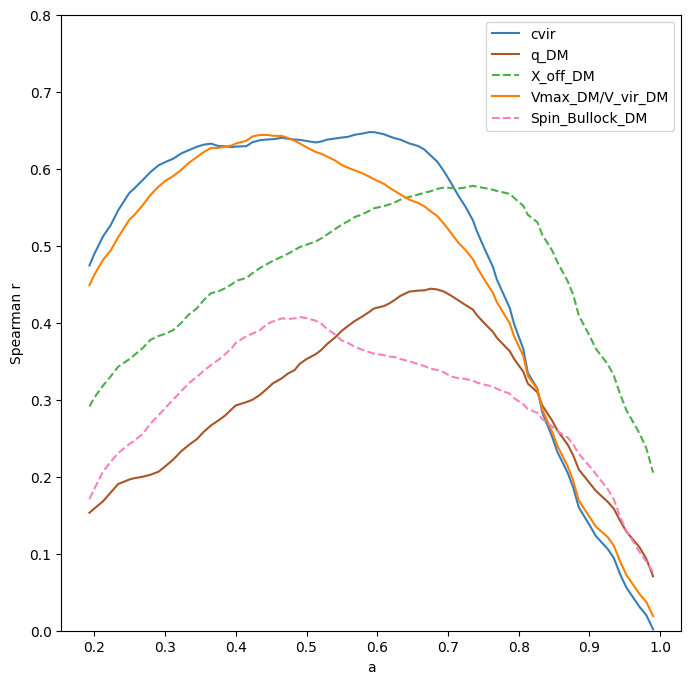

In [100]:
# now plot all correlations (separately), save to png
from multicam.plotting import CB_COLORS
colors_dict = {'cvir': CB_COLORS[0], 
               'Vmax_DM/V_vir_DM': CB_COLORS[1], 
               'X_off_DM': CB_COLORS[2], 
               'Spin_Bullock_DM': CB_COLORS[4],  
               'q_DM': CB_COLORS[5], }
params = {'cvir','Vmax_DM/V_vir_DM', 'X_off_DM', 'Spin_Bullock_DM',  'q_DM', }
assert params.issubset(set(dcat.columns))
assert params.issubset(set(corrs.keys()))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for param in params:
        sgn = (sum(corrs[param] > 0) - sum(corrs[param] < 0)) > 0
        style = '-' if sgn else '--'
        
        corr = np.abs(dcorrs[param])
        ax.plot(scales, corr, style, label=param, color=colors_dict[param])
        ax.set_xlabel("a")
        ax.set_ylabel("Spearman r")
ax.set_ylim(0, 0.8)
ax.legend(loc='best')
